In [1]:
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial

Код от сюда: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Два основных сценария transfer learning:

-  **Finetuning the ConvNet**: Вместо случайной инициализации мы инициализируем сеть с помощью предварительно обученной сети, подобной той, которая обучается на наборе данных imagenet 1000.

-  **ConvNet as fixed feature extractor**: Здесь мы заморозим веса для всей сети, за исключением последнего полностью подключенного слоя. Этот последний полностью подключенный слой заменяется новым со случайными весами, и обучается только этот слой.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

Мы будем использовать `torchvision` и `torch.utils.data` для загрузки
данных.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/car-tires'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Давайте визуализируем несколько обучающих изображений, чтобы понять, как происходит `аугментация` данных.



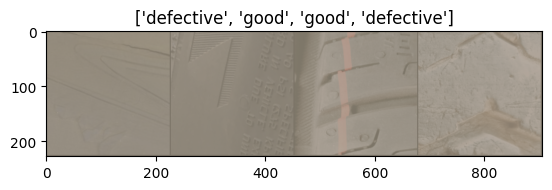

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Теперь напишем общую функцию для обучения модели. Здесь мы
проиллюстрируем:

-  Планирование learning rate
-  Сохранение лучшей модели

Далее параметр `scheduler` является объектом LR scheduler из
`torch.optim.lr_scheduler`.

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_params_path = 'best_model_params.pt'

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print(f'Epoch {epoch} now best with accuracy={best_acc:.4f}')
#                 torch.save(model.state_dict(), best_model_params_path)
                torch.save(model, best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
#     model.load_state_dict(torch.load(best_model_params_path))
    model = torch.load(best_model_params_path)
    model.eval()
    return model

### Visualizing the model predictions

Универсальная функция для отображения прогнозов для нескольких изображений

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}; true: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Create models

In [7]:
def create_resnet18():
    model_ft = models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))
    return model_ft


def create_efficientnet_v2_s():
    model_ft = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))
    return model_ft


def create_swin_t():
    model_ft = models.swin_t(weights='IMAGENET1K_V1')
    num_ftrs = model_ft.head.in_features
    model_ft.head = nn.Linear(num_ftrs, len(class_names))
    return model_ft

## Finetuning the ConvNet

Загрузите предварительно подготовленную модель и сбросьте последний fully connected layer.

In [8]:
model_ft = create_resnet18()
# model_ft = create_efficientnet_v2_s()
# model_ft = create_swin_t()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.1MB/s]


### Train and evaluate

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


 32%|███▏      | 126/393 [00:18<00:39,  6.81it/s]


KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Здесь нам нужно заморозить всю сеть, кроме последнего слоя. Нам нужно установить `requires_grad=False`, чтобы заморозить параметры, чтобы градиенты не вычислялись в обратном `backward()`.

In [ ]:
# model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# # Параметры вновь созданных объектов по умолчанию имеют requires_grad=True
# for param in model_conv.parameters():
#     param.requires_grad = False

# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, len(class_names))

# model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss()

# # Обратите внимание, что оптимизируются только параметры конечного слоя, в отличие от предыдущего.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Уменьшение LR в 0,1 раза каждые 7 эпох
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

На процессоре это займет примерно в два раза меньше времени по сравнению с предыдущим кодом.
Это ожидаемо, поскольку градиенты не нужно вычислять для большей части
сети. Однако `forward ` должна быть вычислена.

In [ ]:
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=5)

In [ ]:
# visualize_model(model_conv)

# plt.ioff()
# plt.show()

## Inference on custom images

Используйте обученную модель, чтобы делать прогнозы для пользовательских изображений и визуализировать
предсказанные метки классов вместе с изображениями.

In [ ]:
# def visualize_model_predictions(model,img_path):
#     was_training = model.training
#     model.eval()

#     img = Image.open(img_path)
#     img = data_transforms['val'](img)
#     img = img.unsqueeze(0)
#     img = img.to(device)

#     with torch.no_grad():
#         outputs = model(img)
#         _, preds = torch.max(outputs, 1)

#         ax = plt.subplot(2,2,1)
#         ax.axis('off')
#         ax.set_title(f'Predicted: {class_names[preds[0]]}')
#         imshow(img.cpu().data[0])
        
#         model.train(mode=was_training)

In [ ]:
# visualize_model_predictions(
#     model_conv,
#     img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
# )

# plt.ioff()
# plt.show()